In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [31]:
# Conventional demodulation
def demapper_sym(symbols_I, symbols_Q, Ns, threshold = 2.0):
   symbol = []
   for i in range(Ns):
        if symbols_I[i] <= -threshold and symbols_Q[i] >= threshold: #-3+3j
            symbol.append(0)
        elif symbols_I[i] <= -threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #-3+1j
            symbol.append(1)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #-3-j
            symbol.append(3)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= -threshold: #-3-3j
            symbol.append(2)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= threshold: #-1+3j
            symbol.append(4)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #-1+j
            symbol.append(5)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #-1-j
            symbol.append(7)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= -threshold: #-1-3j
            symbol.append(6)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= threshold: #1+3j
            symbol.append(12)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #1+j
            symbol.append(13)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #1-j
            symbol.append(15)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= -threshold: #1-3j
            symbol.append(14)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= threshold: #3+3j
            symbol.append(8)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #3+1j
            symbol.append(9)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #3-1j
            symbol.append(11)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= -threshold: #3-3j
            symbol.append(10)
   return np.array(symbol)

# Function tha calculate the bit error rate (BER) of two vectors with 4 bits
def bit_error_rate(y_pred, y_test):
    y_pred = ''.join([f"{sym:04b}" for sym in y_pred])
    y_test = ''.join([f"{sym:04b}" for sym in y_test])

    # Calculate the BER with the two strings
    return np.sum(np.array(list(y_pred)) != np.array(list(y_test)))/len(np.array(list(y_pred)))

# Function that calculate the symbol error rate (SER) of two vectors
def symbol_error_rate(y_pred, y_test):
    # Calculate the SER
    return np.sum(y_pred!=y_test)/len(y_pred)

# Add noise to the signal
def add_noise(signal, target_snr_db):
    X_avg_p = np.mean(signal**2)
    X_avg_db = 10 * np.log10(X_avg_p)
    noise_avg_db_r = X_avg_db - target_snr_db
    noise_avg_p_r = 10 ** (noise_avg_db_r / 10)
    mean_noise = 0
    noise_r = np.random.normal(mean_noise, np.sqrt(noise_avg_p_r), len(signal))
    return signal + noise_r

# Function that sincronize the signals
def sync_signals(tx, rx):
    trans = np.concatenate((tx, tx))
    corr = np.correlate(trans, rx, 'full')
    delay = np.argmax(corr) - len(rx) + 1
    signal = trans[delay:]
    signal = signal[:len(rx)]
    return signal

# Function that demodulate the signal 16-QAM
def demodulate(signal):
    mod_dict = {-3+3j:0, -3+1j:1, -3-3j:2, -3-1j:3,
            -1+3j:4, -1+1j:5, -1-3j:6, -1-1j:7,
            3+3j:8, 3+1j:9, 3-3j:10, 3-1j:11,
            1+3j:12, 1+1j:13, 1-3j:14, 1-1j:15}
    symbols = []
    for i in range(len(signal)):
        symbols.append(mod_dict[signal[i]])
    return np.array(symbols)

In [32]:
# Generate 10000 random symbols with static seed
np.random.seed(0)
Ns = 100000
symbols = np.random.randint(0, 16, Ns)

In [33]:
mod_dict = {0:-3+3j, 1:-3+1j, 2:-3-3j, 3:-3-1j,
            4:-1+3j, 5:-1+1j, 6:-1-3j, 7:-1-1j,
            8:3+3j, 9:3+1j, 10:3-3j, 11:3-1j,
            12:1+3j, 13:1+1j, 14:1-3j, 15:1-1j}

In [34]:
# modulate the symbols
mod_symbols = np.array([mod_dict[sym] for sym in symbols])

In [35]:
# Move 70000 samples to the right
rx = np.concatenate((mod_symbols, mod_symbols))[70000:150000]

In [36]:
OSNR = [4, 6, 8, 10, 12, 14, 16]
Xr = [add_noise(np.real(rx), val) for val in OSNR]
Xi = [add_noise(np.imag(rx), val) for val in OSNR]

In [37]:
X_ch = [np.array(Xr[i]+1j*Xi[i]) for i in range(len(OSNR))]

En este punto, se tienen un conjunto de datos ‘rx’ desplazados y ruidosos que simulan a los datos recibidos del canal.

In [38]:
sync_sym = [sync_signals(mod_symbols, X_ch[i]) for i in range(len(OSNR))]

Aquí se logró encontrar un conjunto de datos transmitidos que están sincronizados con los datos recibidos con el fin de calcular el VER. 

In [39]:
y = [demodulate(sync_sym[i]) for i in range(len(OSNR))]

In [40]:
sym_dem = [demapper_sym(Xr[i], Xi[i], len(Xr[i])) for i in range(len(OSNR))]

In [41]:
# Calculate the BER
ber = [bit_error_rate(sym_dem[i], y[i]) for i in range(len(OSNR))]

## BER KNN

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

ber_knn = []
for i in range(len(OSNR)):
    X = np.array([Xr[i], Xi[i]]).T
    X_train, X_test, y_train, y_test = train_test_split(X, y[i], test_size=0.2, random_state=42)
    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    ber_knn.append(bit_error_rate(y_pred, y_test))

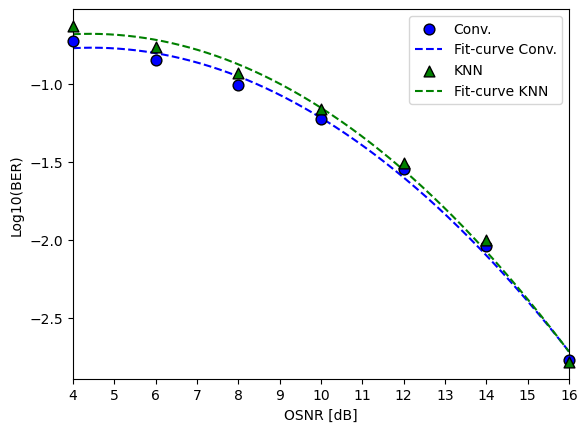

In [48]:
# Fit-curve of the BER
p1 = np.polyfit(OSNR, np.log10(ber), 2)
z1 = np.poly1d(p1)

p2 = np.polyfit(OSNR, np.log10(ber_knn), 2)
z2 = np.poly1d(p2)

x_step = np.linspace(4, 16, 1000) # step between 4 and 16 dB

# Plot ther BER vs OSNR
plt.scatter(OSNR, np.log10(ber), color='blue', edgecolors='black',
            marker='o', s=60, zorder=3, clip_on=False, label='Conv.')
plt.plot(x_step, z1(x_step), '--b', label='Fit-curve Conv.')

plt.scatter(OSNR, np.log10(ber_knn), color='green', edgecolors='black',
            marker='^', s=60, zorder=3, clip_on=False, label='KNN')
plt.plot(x_step, z2(x_step), '--g', label='Fit-curve KNN')

plt.xlabel('OSNR [dB]')
plt.ylabel('Log10(BER)')
plt.xticks(np.arange(4, 17))
plt.xlim(4, 16)
plt.legend()
plt.show()